In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV


In [2]:
df = pd.read_csv('customerGroups.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6620 entries, 0 to 6619
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   g1_1    6620 non-null   float64
 1   g1_2    6620 non-null   int64  
 2   g1_3    6620 non-null   int64  
 3   g1_4    6620 non-null   int64  
 4   g1_5    6620 non-null   int64  
 5   g1_6    6620 non-null   int64  
 6   g1_7    6620 non-null   int64  
 7   g1_8    6620 non-null   int64  
 8   g1_9    6620 non-null   int64  
 9   g1_10   6620 non-null   int64  
 10  g1_11   6620 non-null   int64  
 11  g1_12   6620 non-null   int64  
 12  g1_13   6620 non-null   float64
 13  g1_14   6620 non-null   float64
 14  g1_15   6620 non-null   float64
 15  g1_16   6620 non-null   float64
 16  g1_17   6620 non-null   float64
 17  g1_18   6620 non-null   float64
 18  g1_19   6620 non-null   float64
 19  g1_20   6620 non-null   float64
 20  g1_21   6620 non-null   float64
 21  g2_1    6620 non-null   float64
 22  

In [4]:
df.describe()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
count,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,...,6620.000000,6620.000000,6620.000000,6620.000000,6620.00000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000
mean,2.708779,14.424018,10.485650,24.909668,10.988066,13.412085,10.161027,10.745468,14.169033,3.251057,...,-0.029311,-0.006724,-0.004147,0.008827,0.00000,-0.228426,-0.103728,0.000408,1.917134,1.031722
std,1.857725,10.700787,8.384203,18.174948,5.635985,10.090030,7.495039,7.964247,9.866734,8.481210,...,1.220752,1.068199,0.663238,0.683422,0.32287,3.390902,1.944419,0.092761,0.302175,0.731042
min,1.050000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-27.000000,...,-4.684111,-4.319826,-2.512919,-3.118836,-2.00000,-15.202740,-9.181722,-0.750000,0.000000,0.000000
25%,1.667000,6.000000,4.000000,10.000000,6.000000,5.000000,4.000000,4.000000,6.000000,-2.000000,...,-0.716407,-0.531224,-0.440407,-0.406811,0.00000,-2.222226,-1.293471,-0.054331,1.710000,0.000000
50%,2.150000,13.000000,9.000000,22.000000,11.000000,12.000000,9.000000,9.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.001070,0.00000,-0.119378,-0.012487,0.000000,1.850000,1.000000
75%,2.800000,21.000000,15.000000,36.000000,16.000000,20.000000,15.000000,16.000000,21.000000,7.000000,...,0.654627,0.490504,0.410915,0.450104,0.00000,1.809334,1.035235,0.054825,2.020000,2.000000
max,23.000000,52.000000,47.000000,94.000000,20.000000,61.000000,43.000000,48.000000,52.000000,48.000000,...,4.821136,4.396281,2.987136,2.830550,2.00000,12.562698,8.209578,0.666667,4.330000,2.000000


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,g1_11,g1_12,g1_13,g1_14,g1_15,g1_16,g1_17,g1_18,g1_19,g1_20,g1_21,g2_1,g2_2,g2_3,g2_4,g2_5,g2_6,g2_7,g2_8,g2_9,g2_10,g2_11,g2_12,g2_13,g2_14,g2_15,g2_16,g2_17,g2_18,g2_19,g2_20,g2_21,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
0,4.50,1,3,4,5,1,1,4,6,0,-2,-2,2.505032,2.551406,6.240000,3.608000,0.744000,1.216000,0.003078,0.003028,0.578205,1.83,6,0,6,7,4,0,0,1,4,-1,3,2.888736,2.616855,5.552000,0.728000,0.160000,0.002994,0.002953,0.586149,3.50,1.97,-1,7,6,0,0,0,1,3.223605,1,-3,-2,0,1,4,2,1,-6,-5,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944,1.76,2
1,2.20,24,22,46,10,24,28,18,22,-4,-4,-8,3.718983,3.882271,7.423435,5.048030,0.836178,1.975244,0.784882,0.019448,0.680013,2.80,34,14,48,10,25,16,16,24,9,-8,1,4.065822,4.042015,6.369385,1.511704,1.783791,0.784882,0.033373,0.498949,3.25,1.85,2,1,3,0,0,0,0,1.541039,10,-12,-2,0,12,2,-3,4,-13,-9,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064,1.85,1
2,12.00,7,4,11,18,8,11,2,10,-3,-8,-11,2.244550,2.458087,11.091399,5.853005,0.730046,2.022004,0.043937,0.014264,0.527707,1.30,11,18,29,2,13,3,16,1,10,15,25,4.918483,4.050389,10.029408,2.489174,0.204741,0.022247,0.042004,0.567984,5.00,1.70,-5,10,5,0,0,0,1,2.049024,-11,-7,-18,7,-5,-1,-3,-18,-18,-36,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277,2.05,2
3,1.91,8,5,13,14,6,7,6,9,-1,-3,-4,2.580190,2.683092,9.864426,2.582357,0.656638,1.407549,0.041563,0.021386,0.261785,4.50,5,3,8,17,5,9,7,16,-4,-9,-13,1.964163,2.278147,3.369489,0.665585,2.163561,0.043937,0.010358,0.273886,3.60,1.98,-1,3,2,0,0,0,0,2.284503,5,0,5,-10,0,-3,4,8,1,9,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101,1.82,0
4,2.50,23,16,39,14,33,25,18,27,8,-9,-1,3.470617,3.055989,11.672962,4.554560,1.895740,1.237122,0.941241,0.000062,0.390180,3.00,29,23,52,8,31,22,21,23,9,-2,7,4.527831,4.215284,4.494986,1.419174,1.144728,0.364776,0.008148,0.347568,3.40,1.80,-3,2,-1,1,0,0,0,2.648418,0,-13,-13,10,4,-4,-4,10,-18,-8,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613,1.99,2


In [7]:
df.isna().sum().sum() # check for null values

0

In [8]:
df['target'].unique() # check for errors if target have only described categories

array([2, 1, 0], dtype=int64)

In [9]:
df.columns

Index(['g1_1', 'g1_2', 'g1_3', 'g1_4', 'g1_5', 'g1_6', 'g1_7', 'g1_8', 'g1_9',
       'g1_10', 'g1_11', 'g1_12', 'g1_13', 'g1_14', 'g1_15', 'g1_16', 'g1_17',
       'g1_18', 'g1_19', 'g1_20', 'g1_21', 'g2_1', 'g2_2', 'g2_3', 'g2_4',
       'g2_5', 'g2_6', 'g2_7', 'g2_8', 'g2_9', 'g2_10', 'g2_11', 'g2_12',
       'g2_13', 'g2_14', 'g2_15', 'g2_16', 'g2_17', 'g2_18', 'g2_19', 'g2_20',
       'g2_21', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9',
       'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18',
       'c_19', 'c_20', 'c_21', 'c_22', 'c_23', 'c_24', 'c_25', 'c_26', 'c_27',
       'c_28', 'target'],
      dtype='object')

In [10]:
# changing type of columns to same float64 (int64 -> float64)
#       except for target column
for i in df:
    if i != 'target':
        if df[i].dtype == 'int64':
            df[i] = df[i].astype('float64')
    else:
        df[i] = df[i].astype('category')

In [11]:
# df.info()

In [12]:
df['target']

0       2
1       1
2       2
3       0
4       2
       ..
6615    1
6616    0
6617    1
6618    1
6619    0
Name: target, Length: 6620, dtype: category
Categories (3, int64): [0, 1, 2]

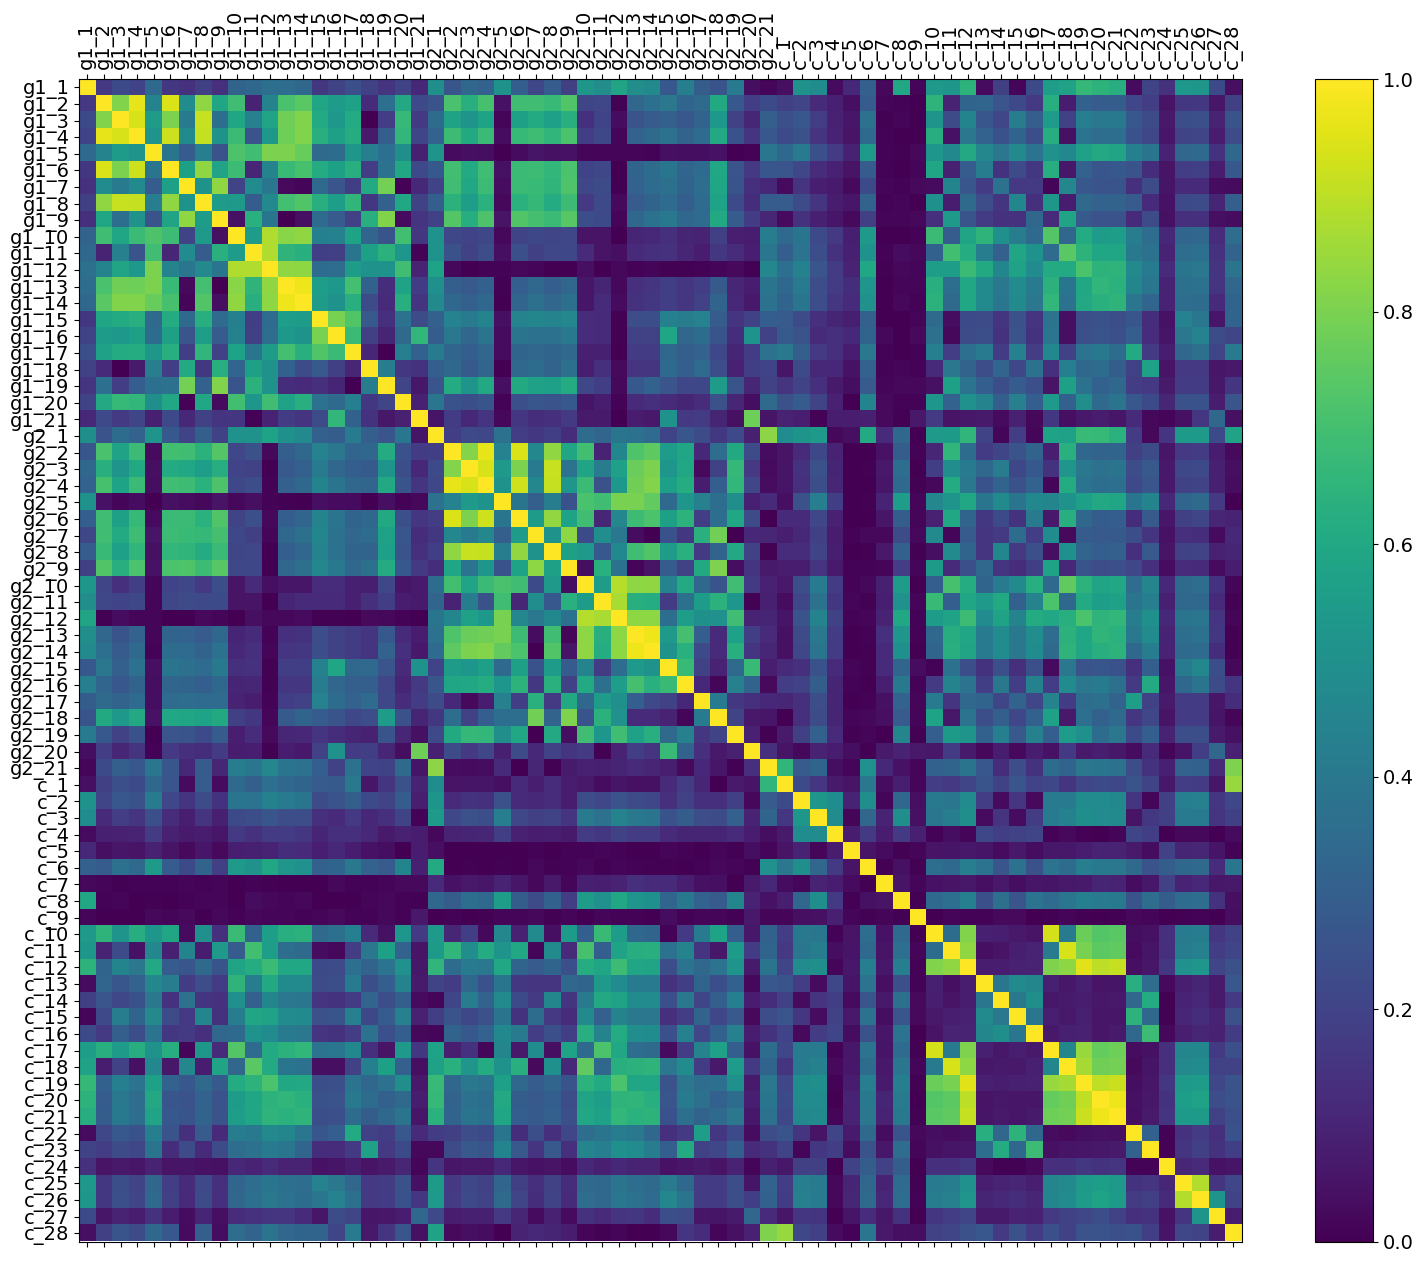

In [13]:
corr = df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr.abs(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Wartość bezwzględna z korelacji Pearsona', fontsize=14)
plt.show(f)

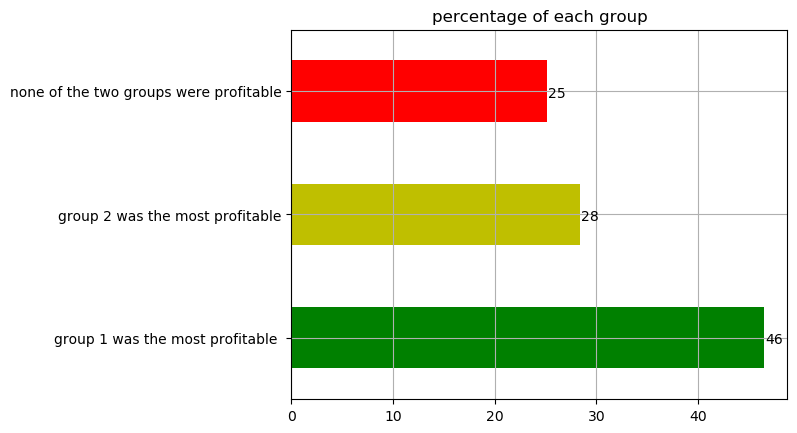

In [14]:
from itertools import cycle, islice

target_vis = df.target.value_counts(normalize=True)*100
target_vis = target_vis.rename({0: 'none of the two groups were profitable', 1: 'group 1 was the most profitable ', 2: 'group 2 was the most profitable'})
my_colors = list(islice(cycle(['g', 'y', 'r']), None, len(df)))
ax = target_vis.plot.barh(title='percentage of each group', grid = True, color = my_colors)
for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_width() + 0.1, p.get_y() + 0.2,))


In [15]:
df = df.drop(['g1_21', 'g2_21', 'c_28'], axis = 1, errors='ignore')
Y = df['target']
X = df.drop(['target'],axis=1)

### normalization

In [16]:

from sklearn.preprocessing import MinMaxScaler
 
trans = MinMaxScaler()
X_trans = trans.fit_transform(X)
X_train, X_test,y_train,y_test = train_test_split(X_trans, Y, test_size = 0.25)

c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


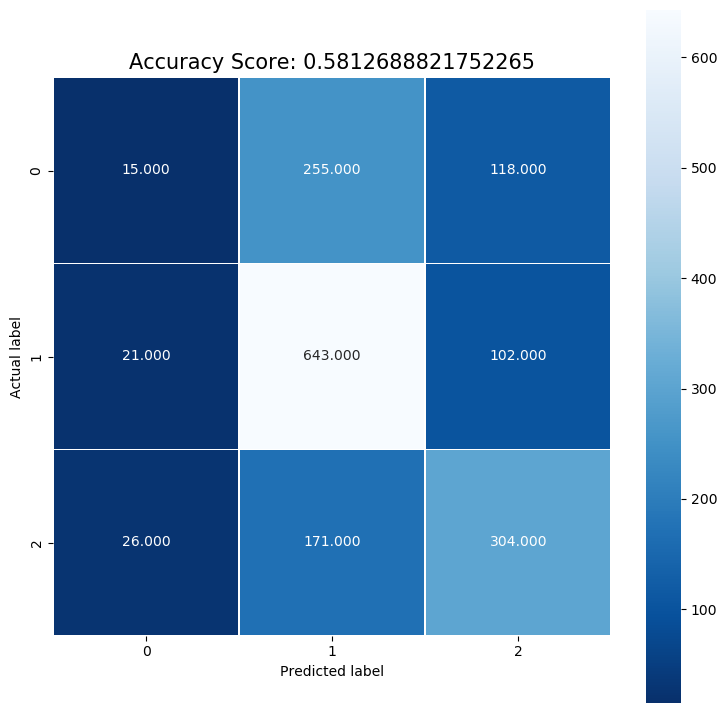

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def logisticRegression_tester(X_tr, X_te, conf_matrix):
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_tr, y_train)
    y_pred = logisticRegr.predict(X_te)
    accuracy = metrics.accuracy_score(y_test, y_pred)

    if conf_matrix == True:
        cm = metrics.confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(9,9))
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
        plt.title(all_sample_title, size = 15)
    else:
        print('Accuracy: ',accuracy)
logisticRegression_tester(X_train, X_test, True)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image


In [19]:
def model_tester(model ,X_tr, y_tr, X_te, conf_matrix, **func_args):
    model = model(**func_args)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    accuracy = accuracy_score(y_test, y_pred)
    #clf_report = classification_report(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    #roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')


    if conf_matrix == True:
        print("Accuracy:", accuracy)
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    else:
        #accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)

    #
    return str(model), accuracy, precision, recall, f1#, roc_auc

### Feature selection

In [20]:
### Feature Selection (numeric input, categorical output)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def top_x_by_fclassif(x):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k=x)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return fs, X_train_fs, X_test_fs

fs, X_train_fs, X_test_fs = top_x_by_fclassif(15)

for i in range(len(fs.scores_)):
	pass
	#print('Feature %d: %f' % (i, fs.scores_[i]))


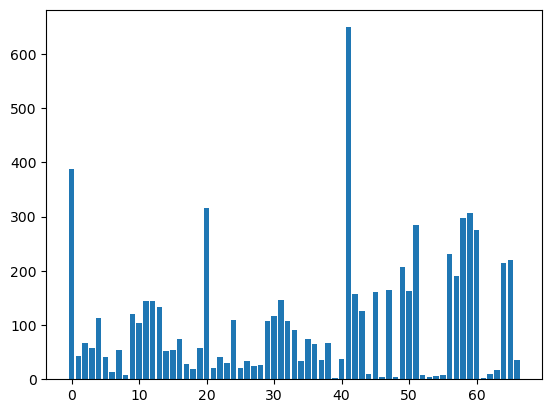

In [21]:

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Based on feature selection scores I will take 15 or less top features

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
from xgboost import XGBClassifier

In [24]:
#Import svm model
from sklearn.svm import SVC

Accuracy: 0.5764350453172206


("SVC(kernel='linear')",
 0.5764350453172206,
 0.5022066443208573,
 0.5764350453172206,
 0.5045013108848174)

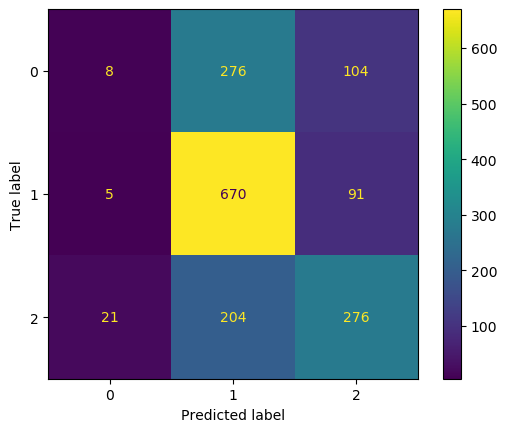

In [25]:
model_tester(SVC, X_train, y_train, X_test, True, C = 1.0, kernel = "linear")

In [26]:
from sklearn.naive_bayes import GaussianNB

c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


Accuracy: 0.567 (0.019)
Accuracy: 0.5782477341389728


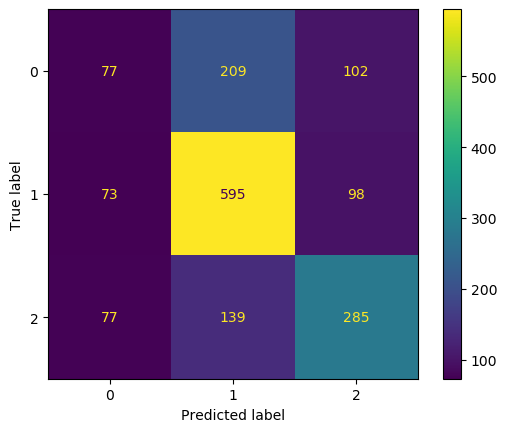

In [27]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
model = HistGradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier()
model.fit(X_train, y_train)
# make a single prediction
y_pred = model.predict(X_test)
#print('Prediction: %d' % y_pred[0])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [29]:
#model_tester(HistGradientBoostingClassifier, X_train, y_train, True)

Accuracy: 0.571 (0.017)
Accuracy: 0.5824773413897281


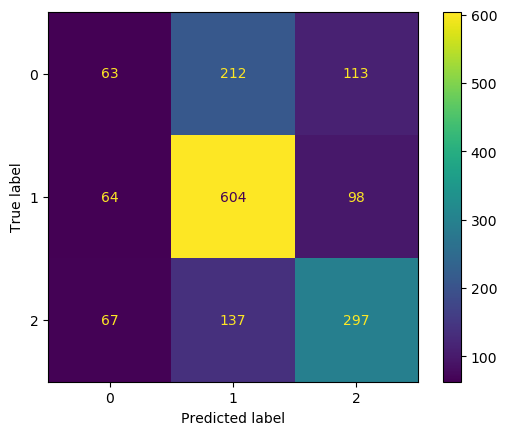

In [30]:
# lightgbm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(X_train, y_train)
# make a single prediction
y_pred = model.predict(X_test)
#print('Prediction: %d' % y_pred[0])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [31]:
from catboost import CatBoostClassifier
#model_tester(CatBoostClassifier, X_train, y_train, True, verbose=0)

In [32]:
# {model : [model_arg1, model_arg2, ...]}

# kernel='linear'
models_dict = {LogisticRegression : [], RandomForestClassifier : [], GradientBoostingClassifier : [], SVC : [],  GaussianNB: [], XGBClassifier : [], HistGradientBoostingClassifier: [], LGBMClassifier: [], CatBoostClassifier : []}

In [33]:
#fs_25, X_train_fs_25, X_test_fs_25 = top_x_by_fclassif(25)
#fs_20, X_train_fs_20, X_test_fs_20 = top_x_by_fclassif(20)
fs_15, X_train_fs_15, X_test_fs_15 = top_x_by_fclassif(15)
fs_10, X_train_fs_10, X_test_fs_10 = top_x_by_fclassif(10)
fs_5, X_train_fs_5, X_test_fs_5 = top_x_by_fclassif(5)
fs_3, X_train_fs_3, X_test_fs_3 = top_x_by_fclassif(3)
fs_train_list = [X_train_fs_15, X_train_fs_10, X_train_fs_5, X_train_fs_3]
fs_test_list = [X_test_fs_15, X_test_fs_10, X_test_fs_5, X_test_fs_3]


In [ ]:
%%capture
models_metrics = {}
for model, model_args in models_dict.items():
    name, accuracy, precision, recall, f1 = model_tester(model, X_train, y_train, False);
    models_metrics[name.split('(')[0] +' all features'] = [accuracy, precision, recall, f1];
    for X_train_fs, X_test_fs in zip(fs_train_list, fs_test_list):
        #print()
        name, accuracy, precision, recall, f1 = model_tester(model, X_train_fs, y_train, False);
        
        models_metrics[name.split('(')[0] + str(X_train_fs.shape[1])] = [accuracy, precision, recall, f1];

Learning rate set to 0.085865
0:	learn: 1.0713324	total: 46.4ms	remaining: 46.4s
1:	learn: 1.0489785	total: 60.5ms	remaining: 30.2s
2:	learn: 1.0286315	total: 76.2ms	remaining: 25.3s
3:	learn: 1.0123228	total: 89.7ms	remaining: 22.3s
4:	learn: 0.9978893	total: 105ms	remaining: 20.8s
5:	learn: 0.9846795	total: 120ms	remaining: 19.9s
6:	learn: 0.9735370	total: 133ms	remaining: 18.9s
7:	learn: 0.9646089	total: 148ms	remaining: 18.3s
8:	learn: 0.9573015	total: 161ms	remaining: 17.7s
9:	learn: 0.9492970	total: 188ms	remaining: 18.6s
10:	learn: 0.9437836	total: 204ms	remaining: 18.3s
11:	learn: 0.9379749	total: 218ms	remaining: 17.9s
12:	learn: 0.9325363	total: 233ms	remaining: 17.7s
13:	learn: 0.9277339	total: 249ms	remaining: 17.6s
14:	learn: 0.9232109	total: 266ms	remaining: 17.5s
15:	learn: 0.9192994	total: 283ms	remaining: 17.4s
16:	learn: 0.9158376	total: 298ms	remaining: 17.2s
17:	learn: 0.9128718	total: 317ms	remaining: 17.3s
18:	learn: 0.9091546	total: 340ms	remaining: 17.6s
19:	lea

In [ ]:
models_metrics_df = pd.DataFrame.from_dict(models_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])

# def highlight_cells(val):
#     color = 'yellow' if val == 5.1 else '#C6E2E9' # Pastel blue
#     return 'background-color: {}'.format(color)

#models_metrics_df.style.format().background_gradient(cmap='Blues')
models_metrics_df.style.highlight_max(color = 'green', axis = 0)

,accuracy,precision,recall,f1
LogisticRegression all features,0.574018,0.503234,0.574018,0.508497
LogisticRegression15,0.574018,0.503234,0.574018,0.508497
LogisticRegression10,0.574018,0.503234,0.574018,0.508497
LogisticRegression5,0.574018,0.503234,0.574018,0.508497
LogisticRegression3,0.574018,0.503234,0.574018,0.508497
RandomForestClassifier all features,0.568580,0.510124,0.568580,0.520567
RandomForestClassifier15,0.578248,0.537649,0.578248,0.537781
RandomForestClassifier10,0.575227,0.526141,0.575227,0.530297
RandomForestClassifier5,0.578852,0.531744,0.578852,0.535599
RandomForestClassifier3,0.578248,0.540765,0.578248,0.537316


In [43]:
%%capture
models_metrics = {}
for model, model_args in models_dict.items():
    #name, accuracy, precision, recall, f1 = model_tester(model, X_train, y_train, False);
    #models_metrics[name.split('(')[0] +' all features'] = [accuracy, precision, recall, f1];
    for X_train_fs, X_test_fs in zip(fs_train_list, fs_test_list):
        #print()
        #name, accuracy, precision, recall, f1 = model_tester(model, X_train_fs, y_train, False);

        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        n_scores = cross_val_score(model(), X_train_fs, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        
        name = str(model)

        models_metrics[name.split("'")[1].split(".")[-1] + str(X_train_fs.shape[1])] = ['%.3f (%.3f)' % (mean(n_scores), std(n_scores))]#, accuracy, precision, recall, f1];

In [44]:
models_metrics_df = pd.DataFrame.from_dict(models_metrics, orient='index', columns=['accuracy (std)'])#, 'accuracy', 'precision', 'recall', 'f1'])

# def highlight_cells(val):
#     color = 'yellow' if val == 5.1 else '#C6E2E9' # Pastel blue
#     return 'background-color: {}'.format(color)

#models_metrics_df.style.format().background_gradient(cmap='Blues')
models_metrics_df.style.highlight_max(color = 'green', axis = 0)

,accuracy (std)
LogisticRegression15,0.574 (0.014)
LogisticRegression10,0.578 (0.015)
LogisticRegression5,0.578 (0.014)
LogisticRegression3,0.581 (0.013)
RandomForestClassifier15,0.560 (0.016)
RandomForestClassifier10,0.559 (0.017)
RandomForestClassifier5,0.533 (0.023)
RandomForestClassifier3,0.489 (0.016)
GradientBoostingClassifier15,0.579 (0.021)
GradientBoostingClassifier10,0.579 (0.019)


In [34]:
X_train_fs.shape, X_test_fs.shape

((4965, 15), (1655, 15))

In [45]:
best_model_acc_cross = {}
#model = 
for X_train_fs, X_test_fs in zip(fs_train_list, fs_test_list):
        #print()
        #name, accuracy, precision, recall, f1 = model_tester(GradientBoostingClassifier, X_train_fs, y_train, X_test_fs, False);
        #[accuracy, precision, recall, f1];
        model = GradientBoostingClassifier()
        name = 'GradientBoostingClassifier'
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        n_scores = cross_val_score(model, X_train_fs, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        best_model_acc_cross[name.split('(')[0] + str(X_train_fs.shape[1])] = ['%.3f (%.3f)' % (mean(n_scores), std(n_scores))]
        #print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [46]:
models_metrics_df = pd.DataFrame.from_dict(best_model_acc_cross, orient='index', columns=[ 'mean accuracy (std)'])

# def highlight_cells(val):
#     color = 'yellow' if val == 5.1 else '#C6E2E9' # Pastel blue
#     return 'background-color: {}'.format(color)

#models_metrics_df.style.format().background_gradient(cmap='Blues')
models_metrics_df.style.highlight_max(color = 'green', axis = 0)

,mean accuracy (std)
GradientBoostingClassifier15,0.579 (0.020)
GradientBoostingClassifier10,0.578 (0.019)
GradientBoostingClassifier5,0.584 (0.020)
GradientBoostingClassifier3,0.589 (0.018)


>2 0.383 (0.020)
>3 0.396 (0.024)
>4 0.423 (0.034)
>5 0.449 (0.024)
>6 0.450 (0.015)
>7 0.452 (0.023)
>8 0.453 (0.025)
>9 0.450 (0.019)


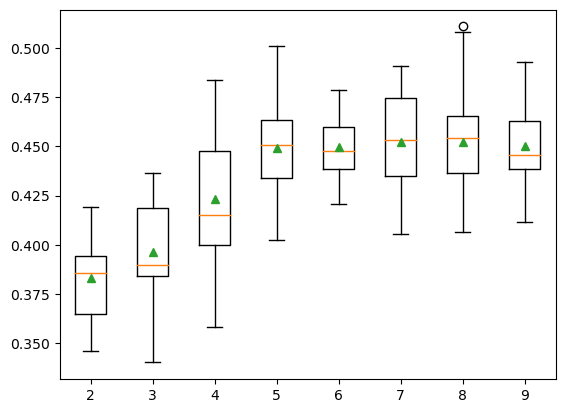

In [37]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [38]:
import pickle

((4965, 67), (4965,))

In [39]:
#training best model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [40]:
print(X_train.shape, y_train.shape, X_test.shape)
model.predict(X_test).shape

(4965, 67) (4965,) (1655, 67)


(1655,)

In [41]:
# creating example in json to post it on uvicorn app
example = X.iloc[0,:]
example.to_json(orient="index")

'{"g1_1":4.5,"g1_2":1.0,"g1_3":3.0,"g1_4":4.0,"g1_5":5.0,"g1_6":1.0,"g1_7":1.0,"g1_8":4.0,"g1_9":6.0,"g1_10":0.0,"g1_11":-2.0,"g1_12":-2.0,"g1_13":2.5050318819,"g1_14":2.5514063764,"g1_15":6.24,"g1_16":3.608,"g1_17":0.744,"g1_18":1.216,"g1_19":0.0030780093,"g1_20":0.0030275547,"g2_1":1.83,"g2_2":6.0,"g2_3":0.0,"g2_4":6.0,"g2_5":7.0,"g2_6":4.0,"g2_7":0.0,"g2_8":0.0,"g2_9":1.0,"g2_10":4.0,"g2_11":-1.0,"g2_12":3.0,"g2_13":2.8887363683,"g2_14":2.6168550926,"g2_15":5.552,"g2_16":0.728,"g2_17":0.16,"g2_18":0.0029936856,"g2_19":0.0029528042,"g2_20":0.5861486486,"c_1":1.97,"c_2":-1.0,"c_3":7.0,"c_4":6.0,"c_5":0.0,"c_6":0.0,"c_7":0.0,"c_8":1.0,"c_9":3.2236053804,"c_10":1.0,"c_11":-3.0,"c_12":-2.0,"c_13":0.0,"c_14":1.0,"c_15":4.0,"c_16":2.0,"c_17":1.0,"c_18":-6.0,"c_19":-5.0,"c_20":-0.3837044864,"c_21":-0.0654487162,"c_22":0.584,"c_23":0.488,"c_24":0.0,"c_25":-3.232,"c_26":-1.944,"c_27":-0.0079435204}'

In [42]:
# creating .pkl file with model in it
pickle.dump(model, open('model.pkl', 'wb'))

Results propobly could be better, if I could talk to the marteking team and learn more about the data.